In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import math

from sklearn.model_selection import KFold

In [14]:
# read data from given file
def read_data(path = None):

    data = pd.read_excel(path)
    
    # drop those records which contain 0 values
    data = data.replace(0, np.NaN)
    data = data.dropna()
    
    # divide the data into features and labels
    X = data.loc[:, ['PM2.5', 'PM10', 'SO2', 'CO', 'NO2', 'O3']]
    Y = data.loc[:, '质量等级']

    return [np.array(X), np.array(Y)]

In [15]:
# read train dataset and test dataset separately
[X_train, Y_train] = read_data('train.xlsx')
[X_test, Y_test] = read_data('test.xlsx')

In [16]:
# my implement of KNN model
def KNN_model(features, X_train, Y_train, K):

    # dimension of the features
    dimension = len(X_train[0]) 
    
    # calculate the Euclid distance between the input and train samples
    distances = []
    for i in range(len(X_train)):
        distance = 0
        for j in range(dimension):
            distance += (features[j] - X_train[i][j]) ** 2
        distances.append(math.sqrt(distance))
    
    # find the K nearest neighbors
    sorted_indices = np.argsort(distances)
    # frequency of each type of label
    label_count = {}
    for i in range(K):
        label = Y_train[sorted_indices[i]]
        label_count[label] = label_count.get(label, 0) + 1

    return max(label_count.items(), key = lambda item : item[1])[0]

In [17]:
# use K-fold cross validation to find the best parameter K
performance = []
kf = KFold(n_splits = 10, shuffle = False)

for K in np.arange(1, 30, 5):
    # use average F1 score to evaluate the performance of a K value
    total_score = 0
    
    for train_index, valid_index in kf.split(X_train):
        KX_train, KX_valid = X_train[train_index], X_train[valid_index]
        KY_train, KY_valid = Y_train[train_index], Y_train[valid_index]
        
        # predicted results of validation set
        results = []
        for i in range(len(valid_index)):
            result = KNN_model(KX_valid[i], KX_train, KY_train, K)
            results.append(result)
        total_score += sklearn.metrics.f1_score(KY_valid, results, average = 'weighted')

    performance.append(total_score / 10)

In [18]:
# configuration for plt to visualize the performance of different K values
def show(performance, Ks):
    
    plt.figure(figsize = (9, 6))
    plt.grid(True, linestyle = '-.')
    plt.xticks(Ks)
    plt.plot(Ks, performance, marker = '.')
    plt.xlabel("K")
    plt.ylabel("F1 score")
    
    best_K = Ks[performance.index(np.max(performance))]
    plt.title("Line chart for F1 score of my KNN model\n(best K = %d)" % best_K)
    plt.show()

    return best_K

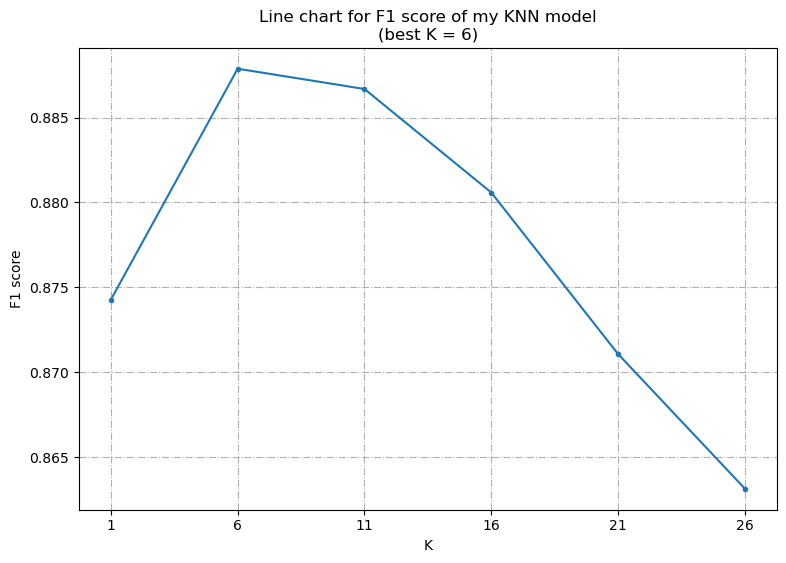

In [19]:
best_K = show(performance, np.arange(1, 30, 5))

In [20]:
# use test set to evaluate our trained model
results = []
for i in range(len(X_test)):
    result = KNN_model(X_test[i], X_train, Y_train, best_K)
    results.append(result)

F1 = sklearn.metrics.f1_score(Y_test, results, average = 'weighted')
print('F1 score: ', F1)
print('details:\n', sklearn.metrics.classification_report(Y_test, results))

F1 score:  0.924185533915133
details:
               precision    recall  f1-score   support

        中度污染       0.91      0.85      0.88        34
           优       0.94      0.97      0.96       101
           良       0.93      0.95      0.94       186
        轻度污染       0.90      0.87      0.89        95
        重度污染       1.00      0.78      0.88         9

    accuracy                           0.92       425
   macro avg       0.94      0.88      0.91       425
weighted avg       0.92      0.92      0.92       425

